In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


In [ ]:
# Load the training and testing datasets
train_df = pd.read_csv('/content/fraudTrain.csv')
test_df = pd.read_csv('/content/fraudTest.csv')

# Preview the first 5 rows of each dataset
print("Training Data Preview:")
print(train_df.head())

print("\nTesting Data Preview:")
print(test_df.head())

# Check basic information
print("\nTraining Data Info:")
print(train_df.info())

print("\nTesting Data Info:")
print(test_df.info())


Training Data Preview:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Gr

In [ ]:
# Convert date columns to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
train_df['dob'] = pd.to_datetime(train_df['dob'])

test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])
test_df['dob'] = pd.to_datetime(test_df['dob'])

# Calculate age at transaction time
train_df['age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days // 365
test_df['age'] = (test_df['trans_date_trans_time'] - test_df['dob']).dt.days // 365

# Extract time-based features
for df in [train_df, test_df]:
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['weekday'] = df['trans_date_trans_time'].dt.weekday

# Create age bins (same bins for both sets)
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']

for df in [train_df, test_df]:
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
    df['age_bin_5'] = pd.cut(df['age'], bins=range(0, 101, 5))

# Drop original dob and trans_date_trans_time columns (not needed anymore)
train_df.drop(columns=['dob', 'trans_date_trans_time'], inplace=True)
test_df.drop(columns=['dob', 'trans_date_trans_time'], inplace=True)


In [ ]:
cols_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 'state',
                'zip', 'job', 'trans_num', 'unix_time']

train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)
train_df

,merchant,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,day,weekday,age_group,age_bin_5
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,36.011293,-82.048315,0,30,0,1,1,20-30,"(25, 30]"
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,49.159047,-118.186462,0,40,0,1,1,30-40,"(35, 40]"
2,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,43.150704,-112.154481,0,56,0,1,1,50-60,"(55, 60]"
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,47.034331,-112.561071,0,52,0,1,1,50-60,"(50, 55]"
4,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,38.674999,-78.632459,0,32,0,1,1,30-40,"(30, 35]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,37.7175,-112.4777,258,36.841266,-111.690765,0,58,12,21,6,50-60,"(55, 60]"
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,39.2667,-77.5101,100,38.906881,-78.246528,0,40,12,21,6,30-40,"(35, 40]"
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,32.9396,-105.8189,899,33.619513,-105.130529,0,52,12,21,6,50-60,"(50, 55]"
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,43.3526,-102.5411,1126,42.788940,-103.241160,0,39,12,21,6,30-40,"(35, 40]"


In [ ]:
categorical_cols = ['merchant', 'category', 'gender', 'age_group', 'age_bin_5']


In [ ]:
for col in categorical_cols:
    train_df[col] = train_df[col].astype(str).fillna('missing')
    test_df[col] = test_df[col].astype(str).fillna('missing')


In [ ]:
# Define the full category list you want
age_group_categories = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']

# Convert to categorical with fixed categories
train_df['age_group'] = pd.Categorical(train_df['age_group'], categories=age_group_categories)
test_df['age_group'] = pd.Categorical(test_df['age_group'], categories=age_group_categories)


In [ ]:
for col in categorical_cols:
    train_df[col] = train_df[col].astype(str).fillna('missing')
    test_df[col] = test_df[col].astype(str).fillna('missing')


In [ ]:
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']

train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, include_lowest=True)
test_df['age_group'] = pd.cut(test_df['age'], bins=bins, labels=labels, include_lowest=True)
train_df

,merchant,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,day,weekday,age_group,age_bin_5
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,36.011293,-82.048315,0,30,0,1,1,20-30,"(25, 30]"
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,49.159047,-118.186462,0,40,0,1,1,30-40,"(35, 40]"
2,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,43.150704,-112.154481,0,56,0,1,1,50-60,"(55, 60]"
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,47.034331,-112.561071,0,52,0,1,1,50-60,"(50, 55]"
4,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,38.674999,-78.632459,0,32,0,1,1,30-40,"(30, 35]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,37.7175,-112.4777,258,36.841266,-111.690765,0,58,12,21,6,50-60,"(55, 60]"
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,39.2667,-77.5101,100,38.906881,-78.246528,0,40,12,21,6,30-40,"(35, 40]"
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,32.9396,-105.8189,899,33.619513,-105.130529,0,52,12,21,6,50-60,"(50, 55]"
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,43.3526,-102.5411,1126,42.788940,-103.241160,0,39,12,21,6,30-40,"(35, 40]"


In [ ]:
train_df['age_group'] = train_df['age_group'].astype(object).fillna('missing')
test_df['age_group'] = test_df['age_group'].astype(object).fillna('missing')

train_df['age_bin_5'] = train_df['age_bin_5'].astype(str)
test_df['age_bin_5'] = test_df['age_bin_5'].astype(str)


In [ ]:
print(train_df[['age_group', 'age_bin_5']].head())


  age_group age_bin_5
0     20-30  (25, 30]
1     30-40  (35, 40]
2     50-60  (55, 60]
3     50-60  (50, 55]
4     30-40  (30, 35]


In [ ]:
categorical_cols = ['merchant', 'category', 'gender', 'age_group', 'age_bin_5']
categories_list = [
    None,  # merchant
    None,  # category
    None,  # gender
    ['<20', '20-30', '30-40', '40-50', '50-60', '60+'],  # age_group
    None   # age_bin_5
]


In [ ]:
combined_age_group = pd.concat([train_df['age_group'], test_df['age_group']]).astype(str).fillna('missing')

le = LabelEncoder()
le.fit(combined_age_group)

train_df['age_group'] = le.transform(train_df['age_group'].astype(str).fillna('missing'))
test_df['age_group'] = le.transform(test_df['age_group'].astype(str).fillna('missing'))


In [ ]:
combined_age_bin_5 = pd.concat([train_df['age_bin_5'], test_df['age_bin_5']]).astype(str).fillna('missing')

le2 = LabelEncoder()
le2.fit(combined_age_bin_5)

train_df['age_bin_5'] = le2.transform(train_df['age_bin_5'].astype(str).fillna('missing'))
test_df['age_bin_5'] = le2.transform(test_df['age_bin_5'].astype(str).fillna('missing'))


In [ ]:
train_df

,merchant,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,day,weekday,age_group,age_bin_5
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,36.011293,-82.048315,0,30,0,1,1,0,3
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,49.159047,-118.186462,0,40,0,1,1,1,5
2,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,43.150704,-112.154481,0,56,0,1,1,3,9
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,47.034331,-112.561071,0,52,0,1,1,3,8
4,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,38.674999,-78.632459,0,32,0,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,37.7175,-112.4777,258,36.841266,-111.690765,0,58,12,21,6,3,9
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,39.2667,-77.5101,100,38.906881,-78.246528,0,40,12,21,6,1,5
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,32.9396,-105.8189,899,33.619513,-105.130529,0,52,12,21,6,3,8
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,43.3526,-102.5411,1126,42.788940,-103.241160,0,39,12,21,6,1,5


<ipython-input-17-788721576>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=train_df, palette='Set2')


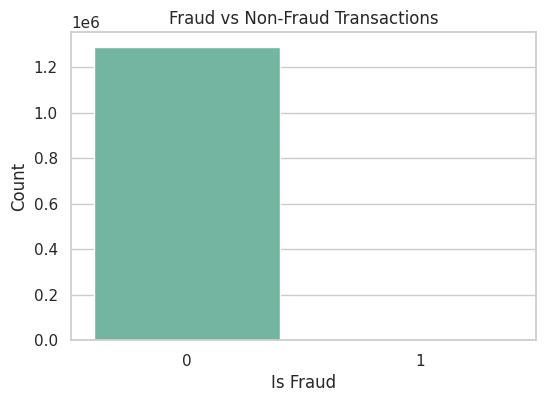

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

#  Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=train_df, palette='Set2')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()



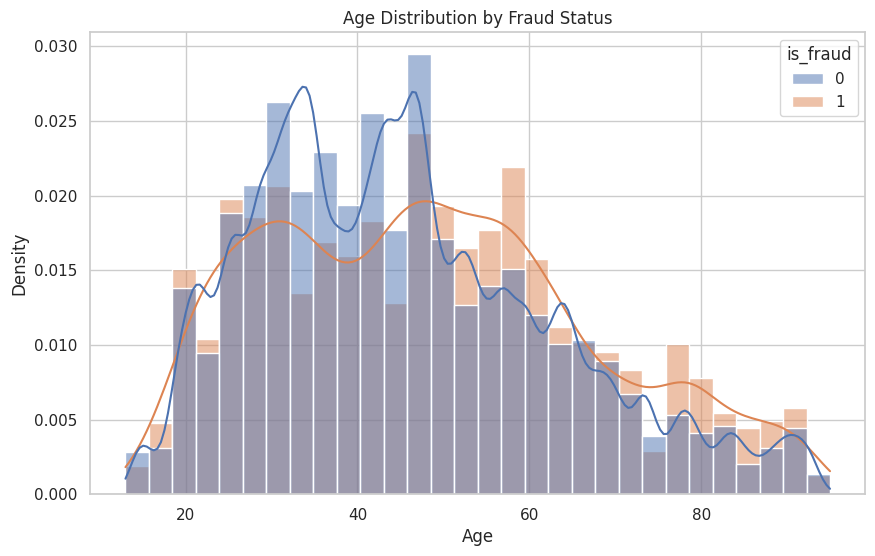

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='age', hue='is_fraud', bins=30, kde=True, stat='density', common_norm=False)
plt.title('Age Distribution by Fraud Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()


<ipython-input-19-2119738618>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud_rate = train_df.groupby('age_group')['is_fraud'].mean().reset_index()
<ipython-input-19-2119738618>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_fraud_rate, x='age_group', y='is_fraud', palette='viridis')


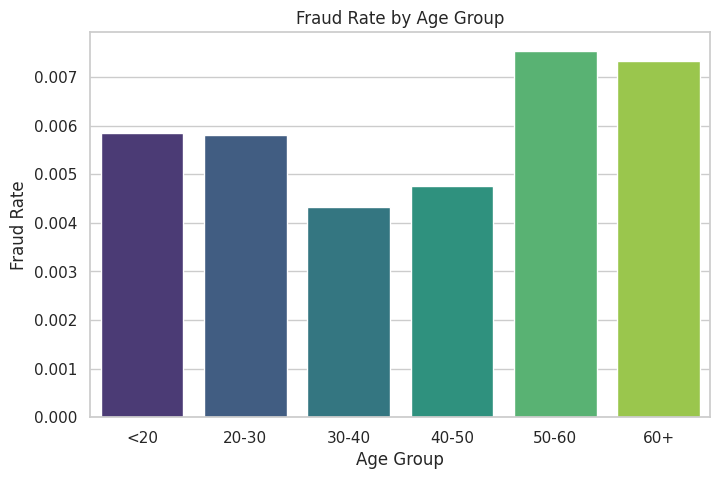

In [ ]:
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])

age_fraud_rate = train_df.groupby('age_group')['is_fraud'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=age_fraud_rate, x='age_group', y='is_fraud', palette='viridis')
plt.title('Fraud Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Fraud Rate')
plt.show()


<ipython-input-20-2305797068>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_counts = train_df[train_df['is_fraud'] == 1].groupby('age_bin_5').size().reset_index(name='fraud_count')
<ipython-input-20-2305797068>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_bin_5', y='fraud_count', data=fraud_counts, palette='rocket')


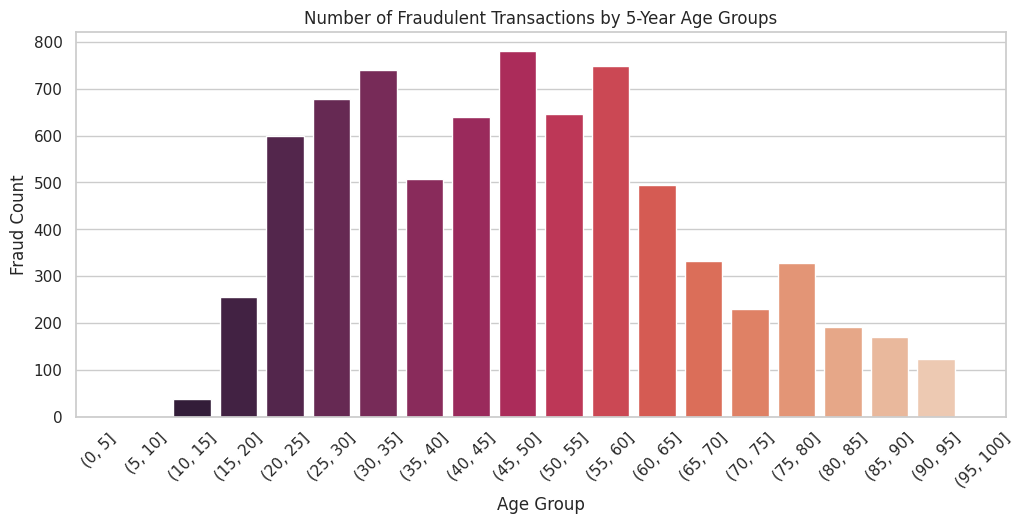

In [ ]:
train_df['age_bin_5'] = pd.cut(train_df['age'], bins=range(0, 101, 5))

fraud_counts = train_df[train_df['is_fraud'] == 1].groupby('age_bin_5').size().reset_index(name='fraud_count')

plt.figure(figsize=(12, 5))
sns.barplot(x='age_bin_5', y='fraud_count', data=fraud_counts, palette='rocket')
plt.title('Number of Fraudulent Transactions by 5-Year Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Fraud Count')
plt.xticks(rotation=45)
plt.show()


<ipython-input-21-1502197839>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='coolwarm')


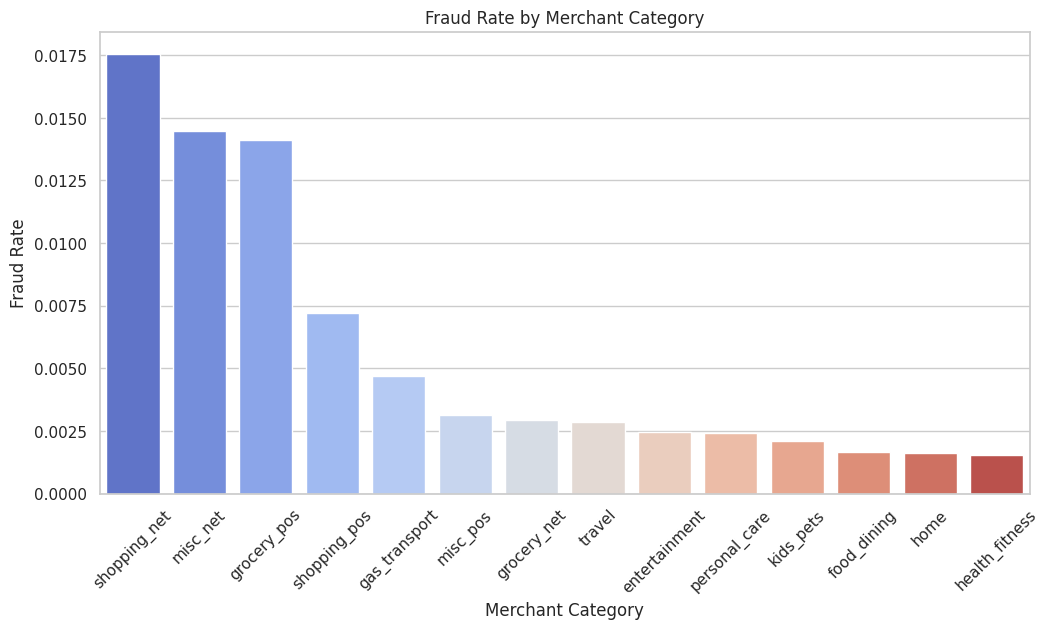

In [ ]:
#  Fraud by Merchant Category
plt.figure(figsize=(12, 6))
fraud_by_category = train_df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Fraud Rate by Merchant Category')
plt.ylabel('Fraud Rate')
plt.xlabel('Merchant Category')
plt.show()


<ipython-input-47-fffcd528cabf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='is_fraud', data=train_df, palette='pastel')


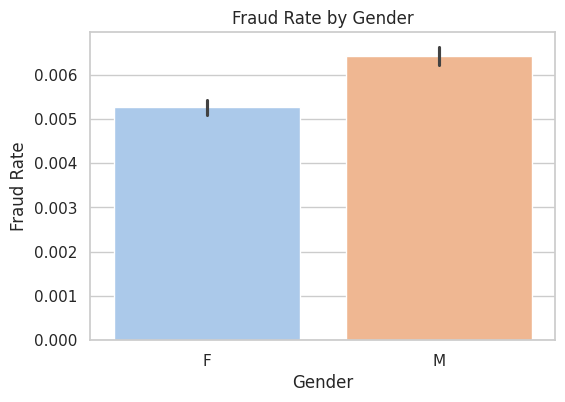

In [ ]:
# Fraud Rate by Gender
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='is_fraud', data=train_df, palette='pastel')
plt.title('Fraud Rate by Gender')
plt.ylabel('Fraud Rate')
plt.xlabel('Gender')
plt.show()



<ipython-input-48-380dcb46a2a7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='city_pop', data=train_df, palette='muted')


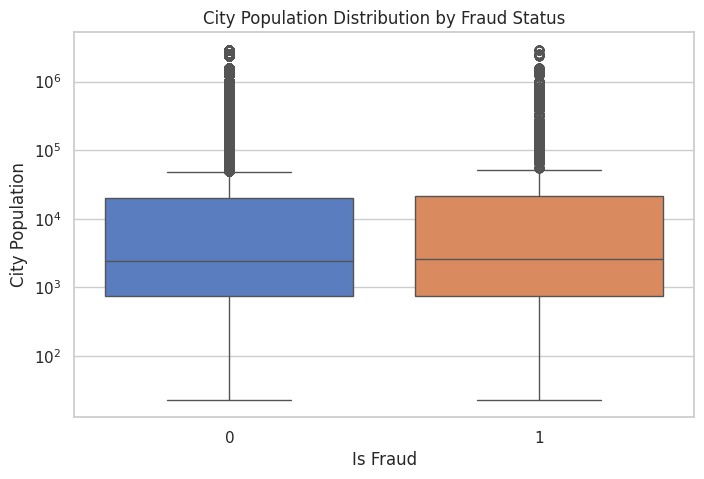

In [ ]:
#  Fraud Distribution by City Population
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fraud', y='city_pop', data=train_df, palette='muted')
plt.title('City Population Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('City Population')
plt.yscale('log')  # Handle skew
plt.show()



<ipython-input-49-bd88e504a5f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='is_fraud', y='amt', data=train_df.sample(1000), jitter=True, palette='Set1', alpha=0.5)


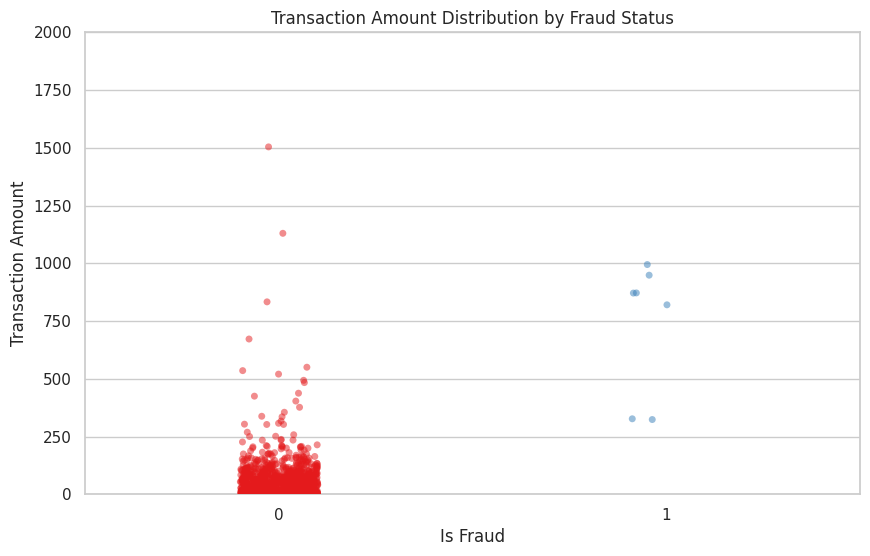

In [ ]:
# Fraud vs. Transaction Amount (Swarmplot)
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='amt', data=train_df.sample(1000), jitter=True, palette='Set1', alpha=0.5)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.ylim(0, 2000)
plt.show()




<ipython-input-26-b108d4da7323>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='is_fraud', data=train_df, palette='coolwarm')


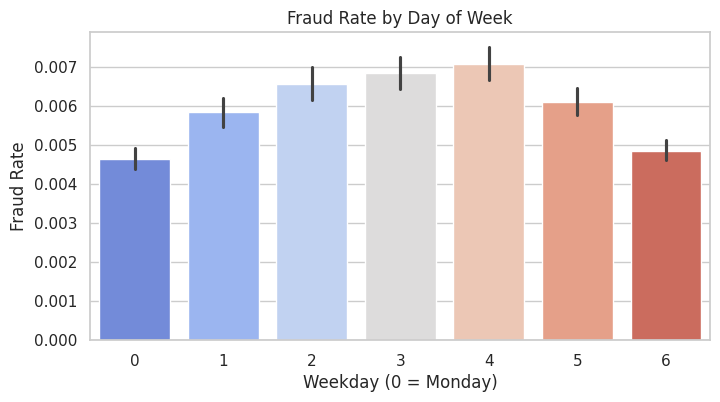

In [ ]:
# Fraud Rate by Day of the Week
plt.figure(figsize=(8, 4))
sns.barplot(x='weekday', y='is_fraud', data=train_df, palette='coolwarm')
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Weekday (0 = Monday)')
plt.ylabel('Fraud Rate')
plt.show()



<ipython-input-27-26f01af43564>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=merchant_fraud_rate.index, y=merchant_fraud_rate.values, palette='Set3')


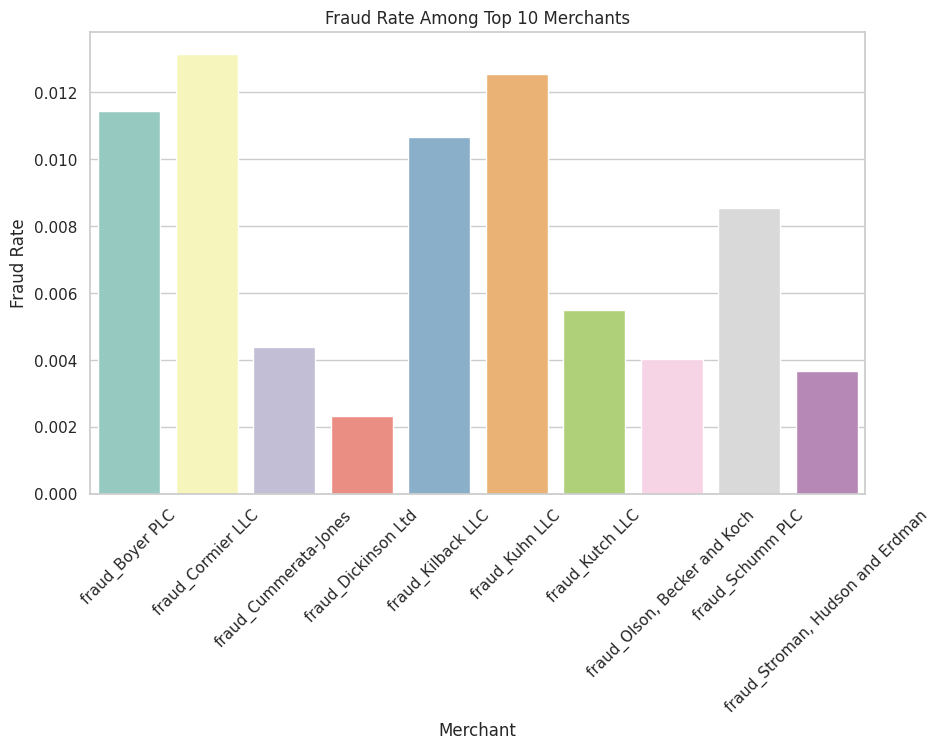

In [ ]:
#  Fraud Rate by Merchant (Top 10 Merchants)
top_merchants = train_df['merchant'].value_counts().head(10).index
merchant_fraud_rate = train_df[train_df['merchant'].isin(top_merchants)].groupby('merchant')['is_fraud'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=merchant_fraud_rate.index, y=merchant_fraud_rate.values, palette='Set3')
plt.xticks(rotation=45)
plt.title('Fraud Rate Among Top 10 Merchants')
plt.xlabel('Merchant')
plt.ylabel('Fraud Rate')
plt.show()

<ipython-input-29-19ee443d12fc>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekend_weekday_fraud_rate, x="is_weekend", y="fraud_rate", palette='viridis')


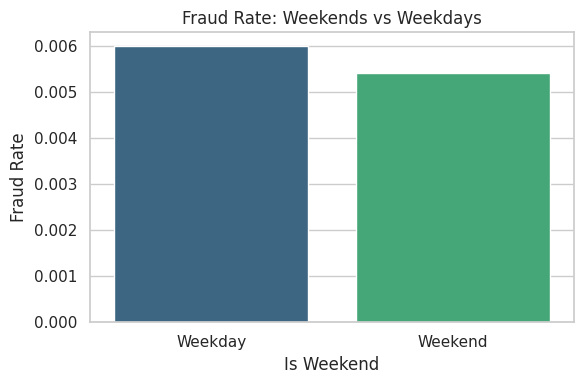

In [ ]:

train_df['is_weekend'] = train_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Group by 'is_weekend' and calculate the mean 'is_fraud'
weekend_weekday_fraud_rate = train_df.groupby('is_weekend')['is_fraud'].mean().reset_index()
weekend_weekday_fraud_rate.columns = ['is_weekend', 'fraud_rate'] # Rename columns for clarity

#  Weekend vs Weekday Fraud Rate
plt.figure(figsize=(6, 4))
# Use the newly created DataFrame directly in the barplot
sns.barplot(data=weekend_weekday_fraud_rate, x="is_weekend", y="fraud_rate", palette='viridis')
plt.title('Fraud Rate: Weekends vs Weekdays')
plt.xlabel('Is Weekend')
plt.ylabel('Fraud Rate')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

<ipython-input-30-9bd554113be9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=amt_bin_fraud_rate, x="amt_bin", y="fraud_rate", palette='viridis')


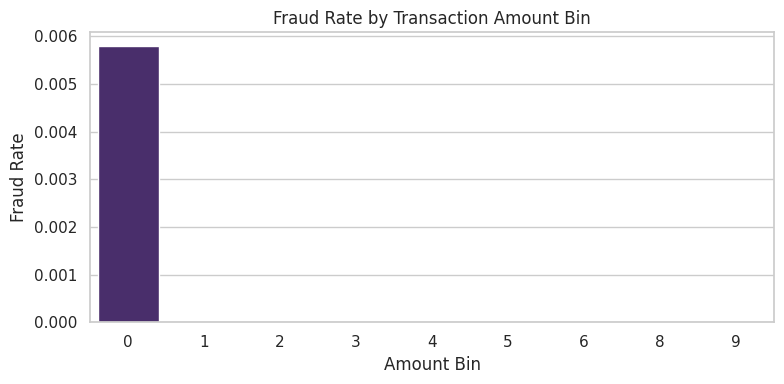

In [ ]:
# Bin transaction amount
train_df['amt_bin'] = pd.cut(train_df['amt'], bins=10, labels=False) # Create 10 bins based on amount

# Calculate fraud rate by amount bin
amt_bin_fraud_rate = train_df.groupby('amt_bin')['is_fraud'].mean().reset_index()
amt_bin_fraud_rate.columns = ['amt_bin', 'fraud_rate'] # Rename columns for clarity

# Fraud Rate by Transaction Amount Bin
plt.figure(figsize=(8, 4))
# Use the newly created DataFrame directly in the barplot
sns.barplot(data=amt_bin_fraud_rate, x="amt_bin", y="fraud_rate", palette='viridis')
plt.title('Fraud Rate by Transaction Amount Bin')
plt.xlabel('Amount Bin')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

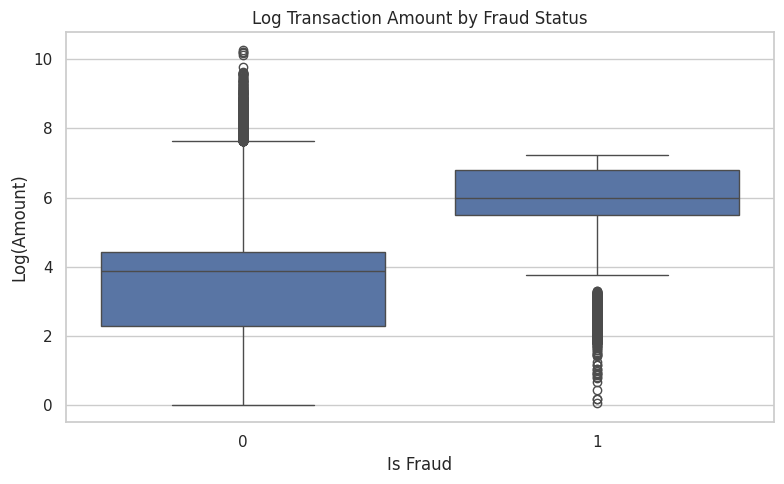

In [ ]:
#  Log-Scaled Transaction Amount by Fraud Status

train_df['log_amt'] = np.log(train_df['amt'])

# Log-Scaled Transaction Amount by Fraud Status
plt.figure(figsize=(8, 5))
# Use the train_df directly now that 'log_amt' is a column
sns.boxplot(data=train_df, x="is_fraud", y="log_amt")
plt.title('Log Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Log(Amount)')
plt.tight_layout()
plt.show()


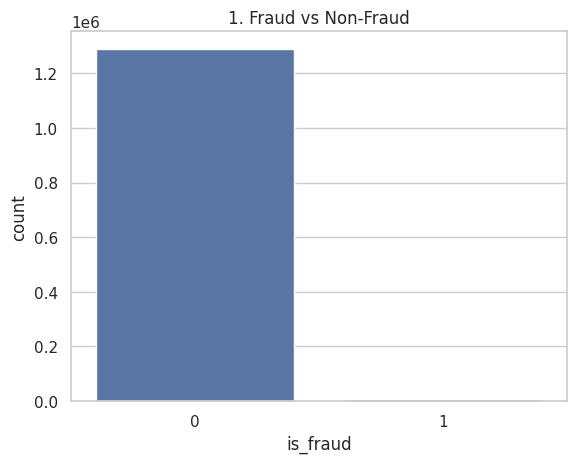

In [ ]:
sns.countplot(x='is_fraud', data=train_df)
plt.title('1. Fraud vs Non-Fraud')
plt.show()


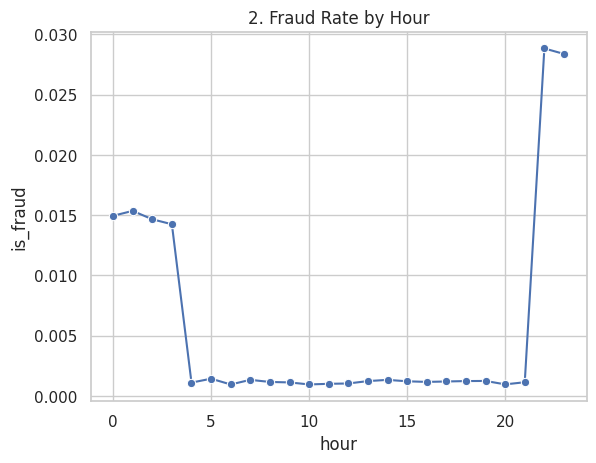

In [ ]:
# Fraud by hour
sns.lineplot(data=train_df.groupby('hour')['is_fraud'].mean().reset_index(), x='hour', y='is_fraud', marker='o')
plt.title('2. Fraud Rate by Hour')
plt.grid(True)
plt.show()


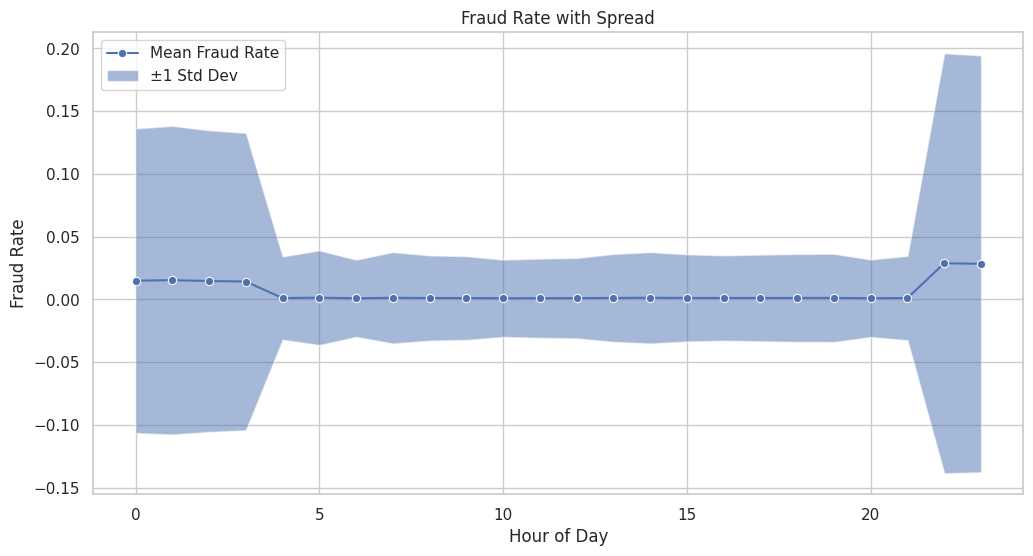

In [ ]:
hourly_values = train_df.groupby('hour')['is_fraud'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_values, x='hour', y='mean', marker='o', label='Mean Fraud Rate')
plt.fill_between(hourly_values['hour'],
                 hourly_values['mean'] - (1 * hourly_values['std']),
                 hourly_values['mean'] + (1 * hourly_values['std']),
                 alpha=0.5, label='±1 Std Dev')

plt.title('Fraud Rate with Spread')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()


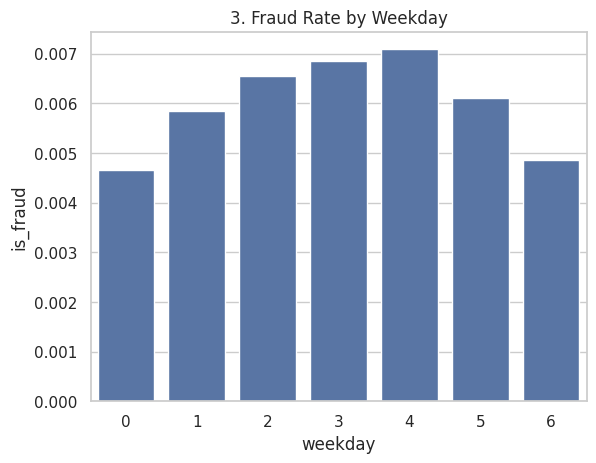

In [ ]:
# Fraud by weekday
sns.barplot(data=train_df.groupby('weekday')['is_fraud'].mean().reset_index(), x='weekday', y='is_fraud')
plt.title('3. Fraud Rate by Weekday')
plt.show()

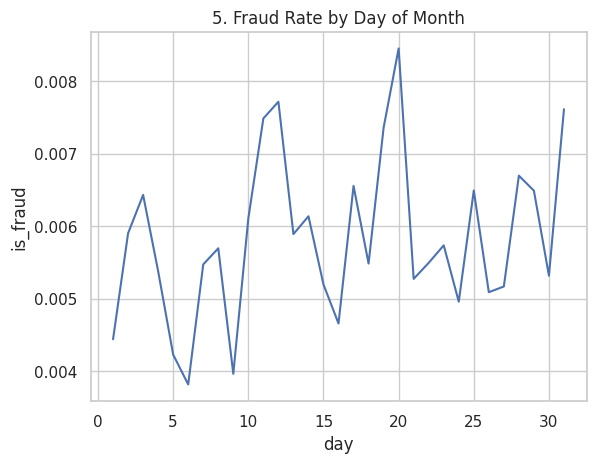

In [ ]:
#  Fraud by day of month
sns.lineplot(data=train_df.groupby('day')['is_fraud'].mean().reset_index(), x='day', y='is_fraud')
plt.title('5. Fraud Rate by Day of Month')
plt.grid(True)
plt.show()

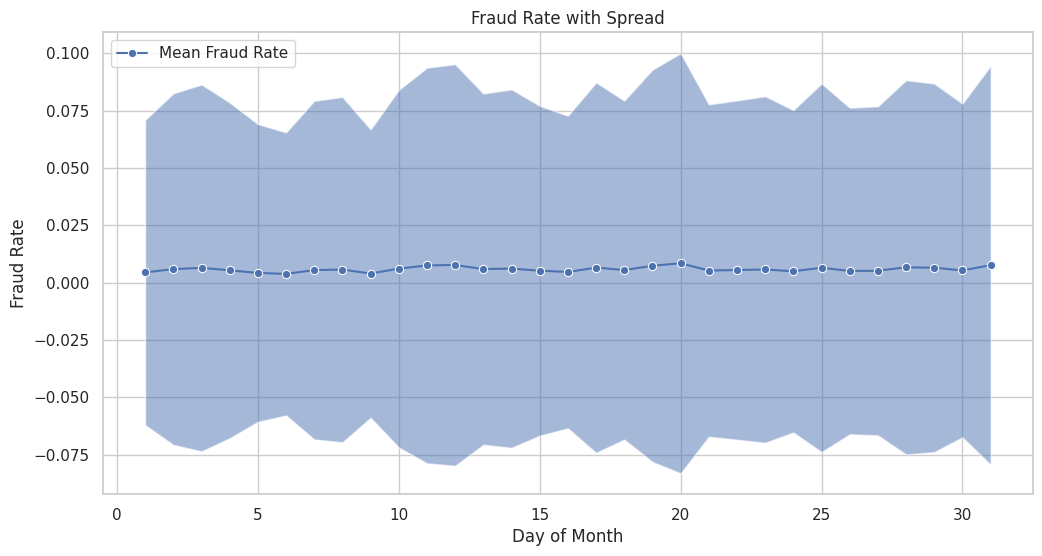

In [ ]:
day_values = train_df.groupby('day')['is_fraud'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=day_values, x='day', y='mean', marker='o', label='Mean Fraud Rate')
plt.fill_between(day_values['day'],
                 day_values['mean'] - (1 * day_values['std']),
                 day_values['mean'] + (1 * day_values['std']),
                 alpha=0.5)

plt.title('Fraud Rate with Spread')
plt.xlabel('Day of Month')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()


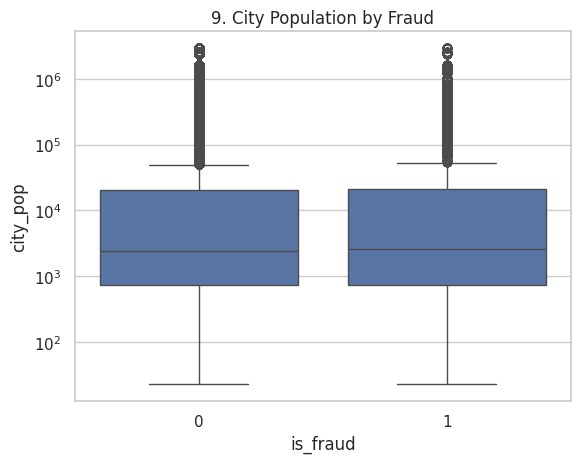

In [ ]:
# Boxplot: city_pop by fraud
sns.boxplot(x='is_fraud', y='city_pop', data=train_df)
plt.yscale('log')
plt.title('9. City Population by Fraud')
plt.show()

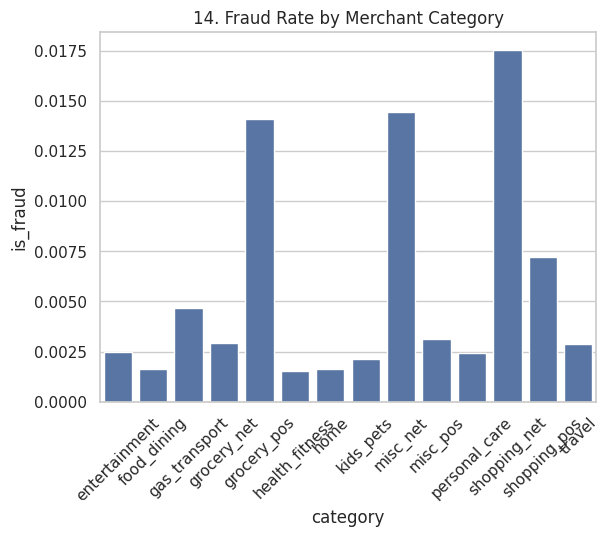

In [ ]:

# Category vs Fraud Rate
sns.barplot(data=train_df.groupby('category')['is_fraud'].mean().reset_index(), x='category', y='is_fraud')
plt.title('14. Fraud Rate by Merchant Category')
plt.xticks(rotation=45)
plt.show()

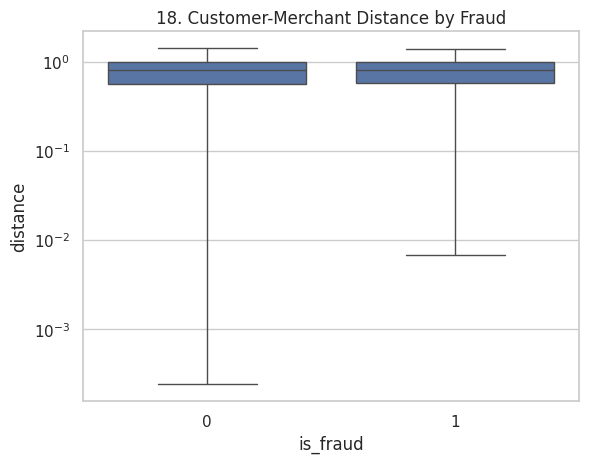

In [ ]:

# Merchant location distance (approx) vs fraud
train_df['distance'] = np.sqrt((train_df['lat'] - train_df['merch_lat'])**2 + (train_df['long'] - train_df['merch_long'])**2)
sns.boxplot(x='is_fraud', y='distance', data=train_df)
plt.yscale('log')
plt.title('18. Customer-Merchant Distance by Fraud')
plt.show()


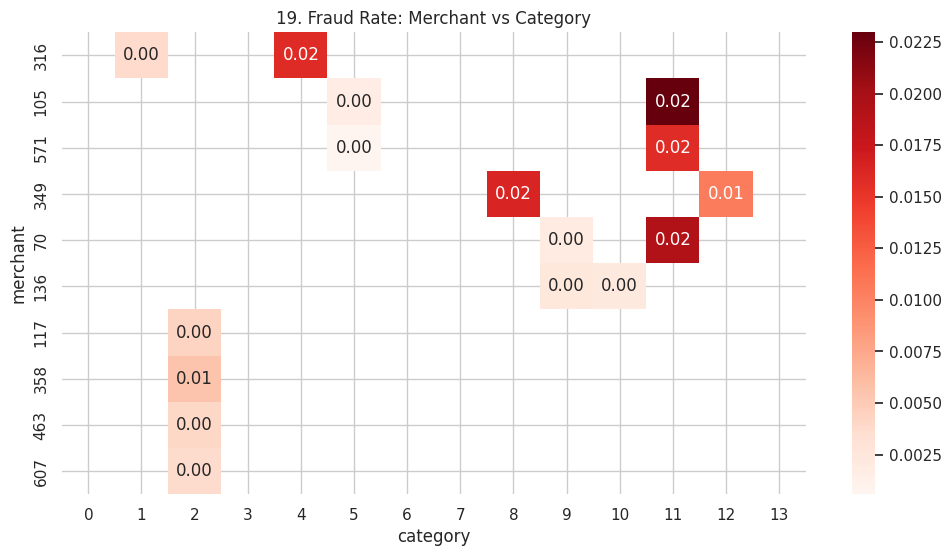

In [ ]:

# Fraud rate by merchant-category combo (heatmap)
pivot = train_df.pivot_table(index='merchant', columns='category', values='is_fraud', aggfunc='mean')
pivot = pivot.loc[train_df['merchant'].value_counts().head(10).index]
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt=".2f")
plt.title('19. Fraud Rate: Merchant vs Category')
plt.show()


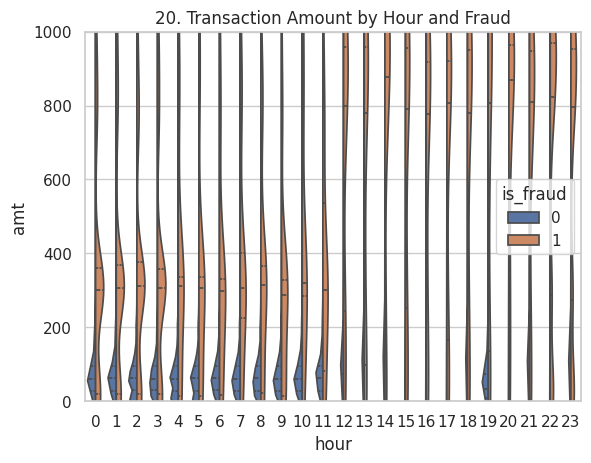

In [ ]:

# Distribution of fraud score by time-of-day
sns.violinplot(data=train_df, x='hour', y='amt', hue='is_fraud', split=True, inner='quartile')
plt.title('20. Transaction Amount by Hour and Fraud')
plt.ylim(0, 1000)
plt.show()

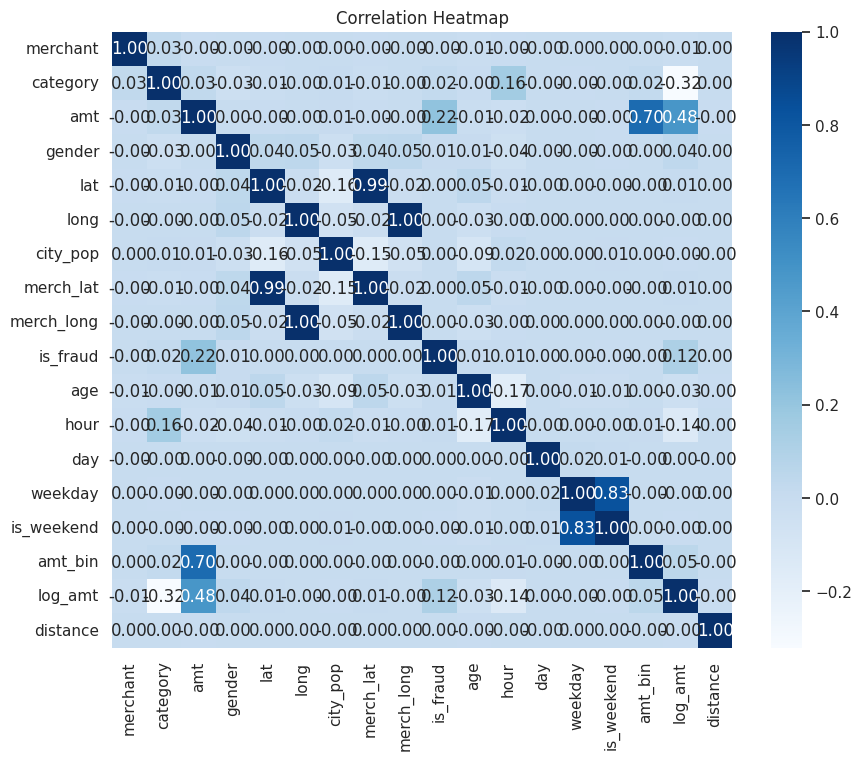

In [ ]:
plt.figure(figsize=(10, 8))
corr = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Encode categorical features (Label Encoding)
label_cols = ['merchant', 'category', 'gender']
le = LabelEncoder()
for col in label_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

from sklearn.preprocessing import StandardScaler

# Define features and target
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training features and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed successfully.")

Scaling completed successfully.


In [ ]:
X_train_scaled

array([[ 0.85165441,  0.45285278, -0.40782607, ..., -0.94197487,
        -1.4196468 , -1.00250175],
       [-0.50688018, -0.56926552,  0.23003923, ..., -0.94197487,
        -0.74100804, -0.42959658],
       [ 0.23459108, -1.59138383,  0.93414872, ..., -0.94197487,
         0.61626946,  0.71621375],
       ...,
       [ 1.27464137, -1.33585425,  0.22193025, ...,  1.33266341,
         0.61626946,  0.42976116],
       [ 0.82677283, -1.33585425,  0.02837499, ...,  1.33266341,
        -0.74100804, -0.42959658],
       [ 0.13506474, -1.33585425, -0.41200532, ...,  1.33266341,
        -1.4196468 , -1.28895433]])

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train)

print("SMOTE applied.")
print("Balanced class distribution:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {int(label)}: {count}")


SMOTE applied.
Balanced class distribution:
Class 0: 1289169
Class 1: 1289169


In [ ]:
# Impute missing values in X_test with median
X_test_imputed = X_test.copy()
for col in ['long', 'city_pop', 'merch_lat', 'merch_long', 'age']:
    median_val = X_test_imputed[col].median()
    X_test_imputed[col].fillna(median_val, inplace=True)

# Now scale after imputation
X_test_scaled = scaler.transform(X_test_imputed)

print("Missing values imputed and test set scaled.")


Missing values imputed and test set scaled.


<ipython-input-44-c6ea3b81bedb>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_imputed[col].fillna(median_val, inplace=True)


In [ ]:
# Drop rows with missing target values from test sets
non_null_idx = ~y_test.isnull()
X_test_scaled = X_test_scaled[non_null_idx]
y_test = y_test[non_null_idx]

print("After dropping NaNs, y_test length:", len(y_test))

After dropping NaNs, y_test length: 555719


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Initialize models
log_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train models
log_model.fit(X_train_balanced, y_train_balanced)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions on test set
log_preds = log_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test_scaled)




In [ ]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# Evaluate both models
evaluate_model(y_test, log_preds, "Logistic Regression")
evaluate_model(y_test, rf_preds, "Random Forest")


--- Logistic Regression Evaluation ---
Accuracy: 0.947748772311186
Precision: 0.053318716364361175
Recall: 0.7482517482517482
F1-Score: 0.09954414364126896
ROC-AUC: 0.8483867678817225
Confusion Matrix:
 [[525077  28497]
 [   540   1605]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719


--- Random Forest Evaluation ---
Accuracy: 0.9810335799207873
Precision: 0.15546252975457606
Recall: 0.882983682983683
F1-Score: 0.26437744276940256
ROC-AUC: 0.9321985943378929
Confusion Matrix:
 [[543285  10289]
 [   251   1894]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.16      0.88      0.26  

In [ ]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train XGBoost on SMOTE-balanced data
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on test set
xgb_preds = xgb_model.predict(X_test_scaled)

# Evaluate model
evaluate_model(y_test, xgb_preds, "XGBoost Classifier")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:26:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost Classifier Evaluation ---
Accuracy: 0.9941607179167888
Precision: 0.3870636550308008
Recall: 0.8787878787878788
F1-Score: 0.5374198146828225
ROC-AUC: 0.9366978228855773
Confusion Matrix:
 [[550589   2985]
 [   260   1885]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.39      0.88      0.54      2145

    accuracy                           0.99    555719
   macro avg       0.69      0.94      0.77    555719
weighted avg       1.00      0.99      1.00    555719



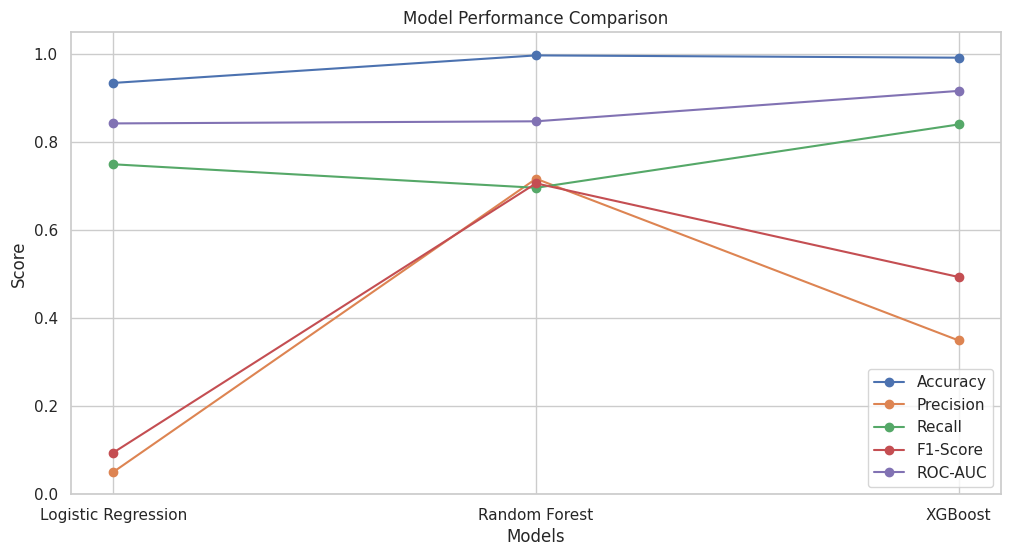

In [ ]:
import matplotlib.pyplot as plt

# Define performance metrics for each model
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy = [0.9348, 0.9974, 0.9922]
precision = [0.0505, 0.7171, 0.3495]
recall = [0.7499, 0.6965, 0.8405]
f1 = [0.0946, 0.7066, 0.4937]
roc_auc = [0.8428, 0.8476, 0.9167]

# Plotting setup
metrics = [accuracy, precision, recall, f1, roc_auc]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Plotting all metrics
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.plot(model_names, metric, marker='o', label=metric_names[i])

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


X_sample, y_sample = resample(X_train_balanced, y_train_balanced, n_samples=10000, stratify=y_train_balanced, random_state=42)

# 2. Random Forest: Tuning
rf_params = {
    'n_estimators': [50, 75, 100],
    'max_depth': [6, 8, 10]

}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_sample, y_sample)
print(" Best RF Params:", rf_search.best_params_)

# 3. XGBoost: Tuning
xgb_params = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    }

xgb_search = RandomizedSearchCV(
    XGBClassifier(subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_sample, y_sample)
print(" Best XGBoost Params:", xgb_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


 Best RF Params: {'n_estimators': 100, 'max_depth': 10}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


 Best XGBoost Params: {'n_estimators': 100, 'learning_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:27:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Retrain with best parameters
final_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
final_xgb = XGBClassifier(n_estimators=100, learning_rate=0.2, subsample=0.8,
                          eval_metric='logloss', random_state=42)

# Fit on full balanced training set
final_rf.fit(X_train_balanced, y_train_balanced)
final_xgb.fit(X_train_balanced, y_train_balanced)

# Predictions
rf_final_preds = final_rf.predict(X_test_scaled)
xgb_final_preds = final_xgb.predict(X_test_scaled)

# Evaluate
evaluate_model(y_test, rf_final_preds, "Random Forest (Tuned)")
evaluate_model(y_test, xgb_final_preds, "XGBoost (Tuned)")




--- Random Forest (Tuned) Evaluation ---
Accuracy: 0.9810335799207873
Precision: 0.15546252975457606
Recall: 0.882983682983683
F1-Score: 0.26437744276940256
ROC-AUC: 0.9321985943378929
Confusion Matrix:
 [[543285  10289]
 [   251   1894]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.16      0.88      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.58      0.93      0.63    555719
weighted avg       1.00      0.98      0.99    555719


--- XGBoost (Tuned) Evaluation ---
Accuracy: 0.9972180184589694
Precision: 0.5980360065466448
Recall: 0.8517482517482518
F1-Score: 0.7026923076923077
ROC-AUC: 0.9247649697360124
Confusion Matrix:
 [[552346   1228]
 [   318   1827]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.60      0.85      0.70

In [ ]:
rf_fast = RandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_cv_scores_fast = cross_val_score(
    rf_fast,
    X_train_balanced,
    y_train_balanced,
    cv=cv_fast,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nRandom Forest Fast CV Results (F1-Score):")
print("Scores per Fold:", rf_cv_scores_fast)
print("Mean F1-Score: {:.4f}".format(rf_cv_scores_fast.mean()))
print("Std Dev: {:.4f}".format(rf_cv_scores_fast.std()))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Random Forest Fast CV Results (F1-Score):
Scores per Fold: [0.96941619 0.96915185 0.96892326]
Mean F1-Score: 0.9692
Std Dev: 0.0002


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.0min finished


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

xgb_fast = XGBClassifier(
    n_estimators=30,          # Reduced from 100 to 30
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds from 5 to 3

cv_scores_fast = cross_val_score(
    xgb_fast,
    X_train_balanced,
    y_train_balanced,
    cv=cv_fast,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nFast Cross-Validation Results (F1-Score):")
print("Scores per Fold:", cv_scores_fast)
print(f"Mean F1-Score: {cv_scores_fast.mean():.4f}")
print(f"Std Dev: {cv_scores_fast.std():.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Fast Cross-Validation Results (F1-Score):
Scores per Fold: [0.98156211 0.9828435  0.9817927 ]
Mean F1-Score: 0.9821
Std Dev: 0.0006


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.7s finished
